In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
print("image shape:", IMAGE_SHAPE)

image shape: (224, 224)


In [4]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)

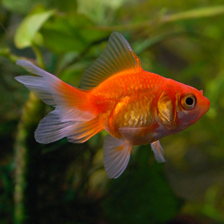

In [5]:
gold_fish

In [6]:
gold_fish = np.array(gold_fish) / 255.0
gold_fish.shape

(224, 224, 3)

In [7]:
gold_fish = gold_fish[np.newaxis, ...]
gold_fish.shape

(1, 224, 224, 3)

In [8]:
result = classifier.predict(gold_fish)
result.shape

1/1 [==============================] - 2s 2s/step


(1, 1001)

In [9]:
result[:5]

array([[ 0.22101453,  2.0474882 ,  9.62256   , ..., -1.4621575 ,
        -0.2814662 , -0.2598485 ]], dtype=float32)

In [10]:
predicted_label = np.argmax(result)
predicted_label

2

In [11]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[predicted_label]

'goldfish'

Using flower dataset

In [12]:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [14]:
data_dir = '.\\datasets\\flower_photos'
data_dir

'.\\datasets\\flower_photos'

In [15]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [16]:
tulips = list(data_dir.glob('tulips/*'))
tulips[:5]

[WindowsPath('datasets/flower_photos/tulips/100930342_92e8746431_n.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10094729603_eeca3f2cb6.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10094731133_94a942463c.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10128546863_8de70c610d.jpg'),
 WindowsPath('datasets/flower_photos/tulips/10163955604_ae0b830975_n.jpg')]

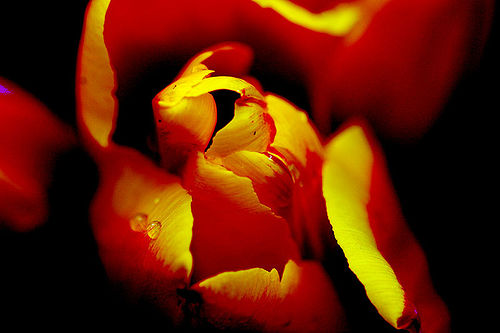

In [17]:
Image.open(tulips[8])

Read flowers images from disk into numpy array using opencv

In [18]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*'))
}

In [19]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [20]:
flowers_images_dict['sunflowers'][:6]

[WindowsPath('datasets/flower_photos/sunflowers/1008566138_6927679c8a.jpg'),
 WindowsPath('datasets/flower_photos/sunflowers/1022552002_2b93faf9e7_n.jpg'),
 WindowsPath('datasets/flower_photos/sunflowers/1022552036_67d33d5bd8_n.jpg'),
 WindowsPath('datasets/flower_photos/sunflowers/10386503264_e05387e1f7_m.jpg'),
 WindowsPath('datasets/flower_photos/sunflowers/10386522775_4f8c616999_m.jpg'),
 WindowsPath('datasets/flower_photos/sunflowers/10386525005_fd0b7d6c55_n.jpg')]

In [23]:
#load data and resize image
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [25]:
y[:5]

[0, 0, 0, 0, 0]

In [26]:
X = np.array(X)
y = np.array(y)

### Train test split

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [29]:
X_trained_scaled = X_train/255
X_test_scaled = X_test/255

### Make prediction using pre-trained model on new flowers dataset

In [32]:
X[0].shape

(224, 224, 3)

In [33]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

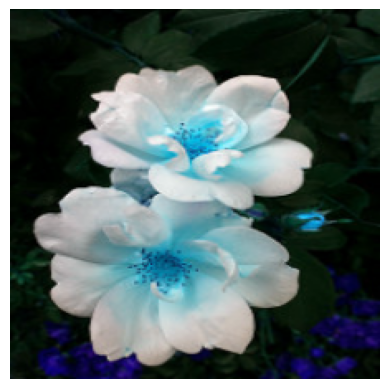

In [34]:
plt.axis('off')
plt.imshow(X[0])

In [35]:
predicted = classifier.predict(np.array([X[0]]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 923ms/step


array([795], dtype=int64)

In [36]:
image_labels[795]

'shower curtain'

### Now take pre-trained model and retrain it using flowers images

In [37]:
# freeze few front layers
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False
)

In [40]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [41]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

model.fit(X_trained_scaled, y_train, epochs=5)

Epoch 1/5



86/86 [==============================] - 49s 502ms/step - loss: 0.8304 - acc: 0.6948
Epoch 2/5
86/86 [==============================] - 42s 485ms/step - loss: 0.4309 - acc: 0.8445
Epoch 3/5
86/86 [==============================] - 44s 506ms/step - loss: 0.3359 - acc: 0.8859
Epoch 4/5
86/86 [==============================] - 44s 513ms/step - loss: 0.2795 - acc: 0.9110
Epoch 5/5
86/86 [==============================] - 51s 589ms/step - loss: 0.2426 - acc: 0.9270


In [42]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 18s 539ms/step - loss: 0.3529 - acc: 0.8791


[0.3528847098350525, 0.8790849447250366]